In [9]:
# Import statements
import json
import numpy as np
import matplotlib as mtplb
import matplotlib.pyplot as plt
import skimage.io as skio
import scipy

In [2]:
# Open the images
hailey = skio.imread("../images/hailey.jpg")
george = skio.imread("../images/george.jpg")

# Opening JSON file
f = open('hailey_george.json',)
   
# returns JSON object as 
# a dictionary
data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

assert(len(im1_points) == len(im2_points))
   
# Closing file
f.close()

In [3]:
mean_points = np.add(im1_points, im2_points)/2
print(mean_points)
x = np.take(mean_points, 0, axis=1)
y = np.take(mean_points, 1, axis=1)

[[  2.5   1.5]
 [592.    1.5]
 [  2.5 740. ]
 [592.5 739. ]
 [304.5  31. ]
 [186.5  50.5]
 [110.5 109.5]
 [ 78.  194. ]
 [ 62.  345.5]
 [ 64.5 441.5]
 [136.  535. ]
 [183.  601.5]
 [255.5 656.5]
 [364.5 649.5]
 [428.5 598. ]
 [478.  527. ]
 [538.  440.5]
 [542.5 338. ]
 [531.5 214. ]
 [462.5 115. ]
 [396.5  45. ]
 [301.5 109.5]
 [193.  133. ]
 [140.  222. ]
 [115.  333. ]
 [118.5 446. ]
 [415.5 137. ]
 [468.  229. ]
 [492.  325.5]
 [490.5 431.5]
 [253.  280.5]
 [162.5 274.5]
 [132.  318.5]
 [173.5 294.5]
 [336.5 277. ]
 [425.  268.5]
 [463.  313. ]
 [421.5 290. ]
 [294.  310.5]
 [275.  355. ]
 [319.  356.5]
 [300.5 422. ]
 [246.  436.5]
 [350.5 437.5]
 [300.5 456. ]
 [300.  504. ]
 [218.5 517. ]
 [300.5 552.5]
 [386.  510. ]
 [301.5 528. ]
 [303.  598.5]
 [165.  339. ]
 [208.5 331.5]
 [246.5 338.5]
 [355.  333. ]
 [391.  325. ]
 [424.5 331. ]
 [177.  496. ]
 [428.5 479. ]
 [186.5 406. ]
 [420.  395.5]]


In [4]:
print(x)
print(y)

[  2.5 592.    2.5 592.5 304.5 186.5 110.5  78.   62.   64.5 136.  183.
 255.5 364.5 428.5 478.  538.  542.5 531.5 462.5 396.5 301.5 193.  140.
 115.  118.5 415.5 468.  492.  490.5 253.  162.5 132.  173.5 336.5 425.
 463.  421.5 294.  275.  319.  300.5 246.  350.5 300.5 300.  218.5 300.5
 386.  301.5 303.  165.  208.5 246.5 355.  391.  424.5 177.  428.5 186.5
 420. ]
[  1.5   1.5 740.  739.   31.   50.5 109.5 194.  345.5 441.5 535.  601.5
 656.5 649.5 598.  527.  440.5 338.  214.  115.   45.  109.5 133.  222.
 333.  446.  137.  229.  325.5 431.5 280.5 274.5 318.5 294.5 277.  268.5
 313.  290.  310.5 355.  356.5 422.  436.5 437.5 456.  504.  517.  552.5
 510.  528.  598.5 339.  331.5 338.5 333.  325.  331.  496.  479.  406.
 395.5]


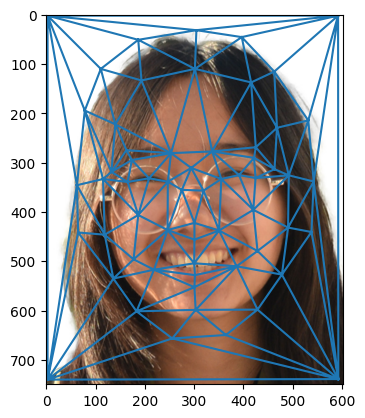

In [5]:
triangulation = mtplb.tri.Triangulation(x, y)
triangles = triangulation.get_masked_triangles()

plt.triplot(triangulation)
plt.gca().invert_yaxis()

plt.imshow(hailey)

In [6]:
# print(triangles)

In [11]:
im1_x = np.take(im1_points, 0, axis=1)
im1_y = np.take(im1_points, 1, axis=1)

im2_x = np.take(im2_points, 0, axis=1)
im2_y = np.take(im2_points, 1, axis=1)

In [ ]:
def createAvgShape(t, x, y):
    # Computer linear interpolation
    T = np.linalg.solve(x, y)
    T_inv = np.linalg.solve(y, x)
    return np.add(((1 - t) * im1_points), (t * im2_points))

In [10]:
# TODO
def computeAffine(tri1_pts, tri2_pts):
    # Img to avg img
    T = np.linalg.solve(tri1_pts, tri2_pts)
    T_inv = np.linalg.solve(tri2_pts, tri1_pts)

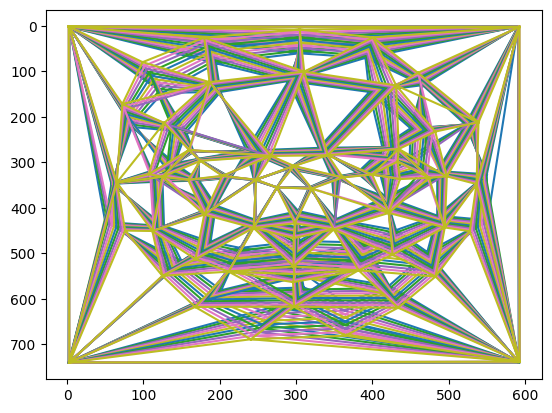

In [8]:
seq = []
for t in np.arange(0, 1, 0.1):
    # Compute the avg shape
    avg_shape = createAvgShape(t, im1_x, im1_y)
    x = np.take(avg_shape, 0, axis=1)
    y = np.take(avg_shape, 1, axis=1)
    avg_triangulation = mtplb.tri.Triangulation(x, y)
    avg_triangles = avg_triangulation.get_masked_triangles()

    plt.triplot(avg_triangulation)
plt.gca().invert_yaxis()

    # assert(len(triangles) == len(avg_triangles))
    # for i in range(len(triangles)):
        # Affine warp the triangle in the triangulation from the original images into this avg triangle
        # A = computeAffine(triangles[i], avg_triangles[i])

        # For each pixel in the triangle, find the corresponding points in each image and set value to
        # weighted average (crossdissolve each triangle)

        # Add frame to sequence
        # seq.append()

        # ...